46/46 ━━━━━━━━━━━━━━━━━━━━ 342s 7s/step - accuracy: 0.0838 - loss: 2.7929 - val_accuracy: 0.0995 - val_loss: 2.7532
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 365s 8s/step - accuracy: 0.0838 - loss: 2.7929 - val_accuracy: 0.0995 - val_loss: 2.7532
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 408s 9s/step - accuracy: 0.0838 - loss: 2.7929 - val_accuracy: 0.0995 - val_loss: 2.7532
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 82978s 1844s/step - accuracy: 0.0838 - loss: 2.7929 - val_accuracy: 0.0995 - val_loss: 2.7532


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
预测概率(%): [np.float32(3.31), np.float32(3.75), np.float32(10.79), np.float32(10.66), np.float32(14.2), np.float32(6.53), np.float32(14.57), np.float32(14.63), np.float32(20.3), np.float32(1.25)]


IndexError: list index out of range

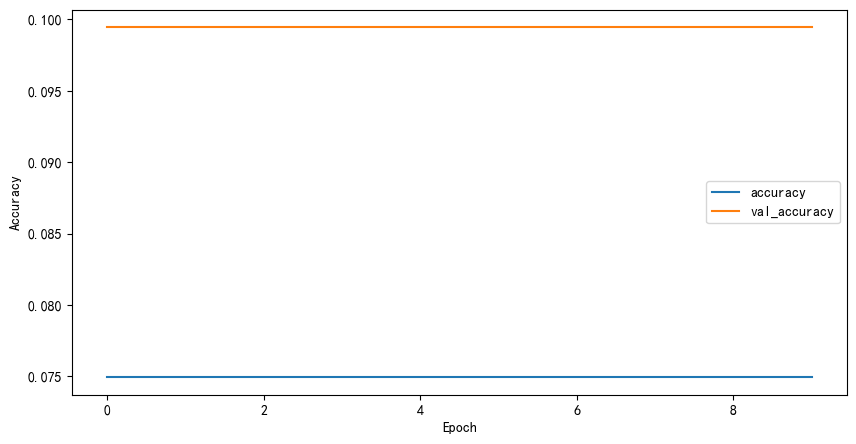

In [1]:
from locale import normalize

import keras.layers
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE

'''
    转移学习,采用部分的模型,再加上自定义的输入层和辨识层,就能够不受限于模型原先辨识的对象,也就是转移学习(transfer learning)

    使用ResNet152V2模型,辨识花朵数据集
    加载ResNet部分模型 ----> 加载flower数据集  ---> 特征缩放 ---> 建立模型 ---> 模型训练  --->预测
    数据来源: https://www.tensorflow.org/tutorials/load_data/images
'''
import tensorflow as tf
from keras.applications.resnet_v2 import  ResNet152V2
from keras.preprocessing import image
from keras.applications.resnet_v2 import preprocess_input
from keras.applications.resnet_v2 import decode_predictions
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model
import numpy as np
import tarfile
import os


import pathlib
# 1.获取数据
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# archive = tf.keras.utils.get_file(fname='flower_photos.tgz', origin=dataset_url)
# data_dir = pathlib.Path(archive).with_suffix('')
#
# # 手动解压到当前目录
# with tarfile.open(archive) as tar:
#     tar.extractall(path='.', filter="data")

## 统计flower_photos目录及子目录下的所有图片的总数
data_dir = 'flower_photos'
num_images = sum([len(files) for r, d, files in os.walk(data_dir)])
print("Total number of images: ", num_images)

print("=========================================")

# 2. 加载数据集
batch_size = 64
img_height = 224
img_width = 224

## 2.1加载flower训练数据
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

## 2.2 加载flower验证数据
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# 3.特征工程处理
normalization_layer = keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
# 4.ResNet152V2模型
resnet_152_model = ResNet152V2(weights='imagenet', include_top=True, input_shape=(img_height, img_width, 3))
## 共有152层卷积层/池化层,加上其他类型共566层。 最后两层为GlobalAveragePooling、Dense,将include_top=False,这两层将被移除。
# resnet_152_model.summary()

# 5.建立模型结构:使用Function API加上自定义的辨识层(GlobalAveragePooling、Dense),再指定模型的输入输出
resnet_152_model = ResNet152V2(weights='imagenet', include_top=False)
x = resnet_152_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)

## 指定自定义的输入层和输出层
new_model = Model(inputs=resnet_152_model.input, outputs=predictions)

## 模型前段不需要训练
for layer in new_model.layers:
    layer.trainable = False

## 设置优化器、损失函数、效果衡量指标的类别
new_model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# 6.模型训练:设定缓存、预存取,提升训练效率
AUTOTUNE = tf.data.AUTOTUNE
normalized_ds = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

history = new_model.fit(normalized_ds, validation_data=normalized_val_ds, epochs=10)

# 7.绘制训练过程的准确率图
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

# 8.显示辨识的类别
print(train_ds.class_names)

# 9.保存模型
new_model.save('resnet_152_model.h5')
new_model = tf.keras.models.load_model('resnet_152_model.h5')

# 10.预测图片
img_path = 'img_test/rose1.png'
img = image.load_img(img_path, target_size=(img_height, img_width))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
predictions = new_model.predict(x)
# 10.显示预测结果
y_pred = [round(i * 100, 2) for i in predictions[0]]
print(f'预测概率(%): {y_pred}')
print(f'预测类别: {train_ds.class_names[np.argmax(predictions)]}')